In [1]:
# validationf VeRITAS
# we validate how well veritas is doing when we cannot ask too many question
# Typically, we want to evaluate performance in conjunction with a CAT framework
# Conclusion: It seems CAT's question generation is not abest for Veritas
# we can ask similar number of questions, but get much better performance if we 
# generate the questiosn differently, namely questions that not only 
# take into account the goal of getting to diagnosis, but also detection of malingering

In [2]:
import sys
import pandas as pd
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()
import pylab as plt
from sklearn import metrics
from zedstat import zedstat

In [4]:
# resf is generated using calc_parallel_res.py
#! ./calc_parallel_res.py --res ./response_jsons/ --V ./veritas_models/veritas_010.pkl.gz --o ./res_R20_model10.csv
#! ./calc_parallel_res.py --res ./response_jsons/validation_index20.pkl.gz --V ./veritas_models/veritas_009.pkl.gz --o ./res_R20_model9.csv
#! ./calc_parallel_res.py --res ./response_jsons/experiment.pkl.gz --V ./veritas_models/veritas_009.pkl.gz --o ./res_exp_model9.csv

In [47]:
C0=1
C1=0.76
C2=1.35
def malinger(row):
    if (row.lower_threshold < C0) and (row.score > C2):
        return -1
    if (row.veritas > C1) and (row.score > C2):
        return -1    
    if (row.score < C2):
        return 0
    else:
        return 1

In [48]:
resf=pd.read_csv('res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
DX=True
if DX:
    resf['dx'] = [int(x[-1]) for x in resf.index.values]
else:
    resf['dx'] = [x>C2 for x in resf.score.values]

resf['mg']=resf.apply(malinger,axis=1)

In [50]:
if DX:
    fpr, tpr, thresholds = metrics.roc_curve(resf.dx.values.astype(int),resf.score.values.astype(float), pos_label=1)
    ff=pd.DataFrame(tpr,fpr,columns=['tpr']).assign(threshold=thresholds)
    ff.index.name='fpr'
    zt=zedstat.processRoc(df=ff.reset_index(),
                          order=3, 
                          total_samples=304,
                          positive_samples=86,
                          alpha=0.01,
                          prevalence=0.5)
    zt.smooth(STEP=0.001)
    zt.allmeasures(interpolate=True)
    zt.usample(precision=3)
    Z=zt.get()
    print(Z[Z.ppv>.875].tail(10))

            tpr       ppv       acc       npv       LR+       LR-  threshold
fpr                                                                         
0.083  0.546512  0.879305  0.731971  0.677113  8.915798  0.487412   1.278034
0.084  0.549248  0.878840  0.732845  0.678231  8.842099  0.484955   1.274424
0.085  0.551984  0.878376  0.733718  0.679349  8.768401  0.482498   1.270813
0.086  0.554720  0.877911  0.734591  0.680468  8.694703  0.480042   1.267203
0.087  0.557456  0.877446  0.735465  0.681586  8.621004  0.477585   1.263592
0.088  0.560192  0.876981  0.736338  0.682704  8.547306  0.475129   1.259981
0.089  0.562927  0.876516  0.737211  0.683823  8.473607  0.472672   1.256371
0.090  0.565663  0.876051  0.738084  0.684941  8.399909  0.470216   1.252760
0.091  0.568399  0.875586  0.738958  0.686059  8.326210  0.467759   1.249149
0.092  0.571135  0.875121  0.739831  0.687178  8.252512  0.465302   1.245539


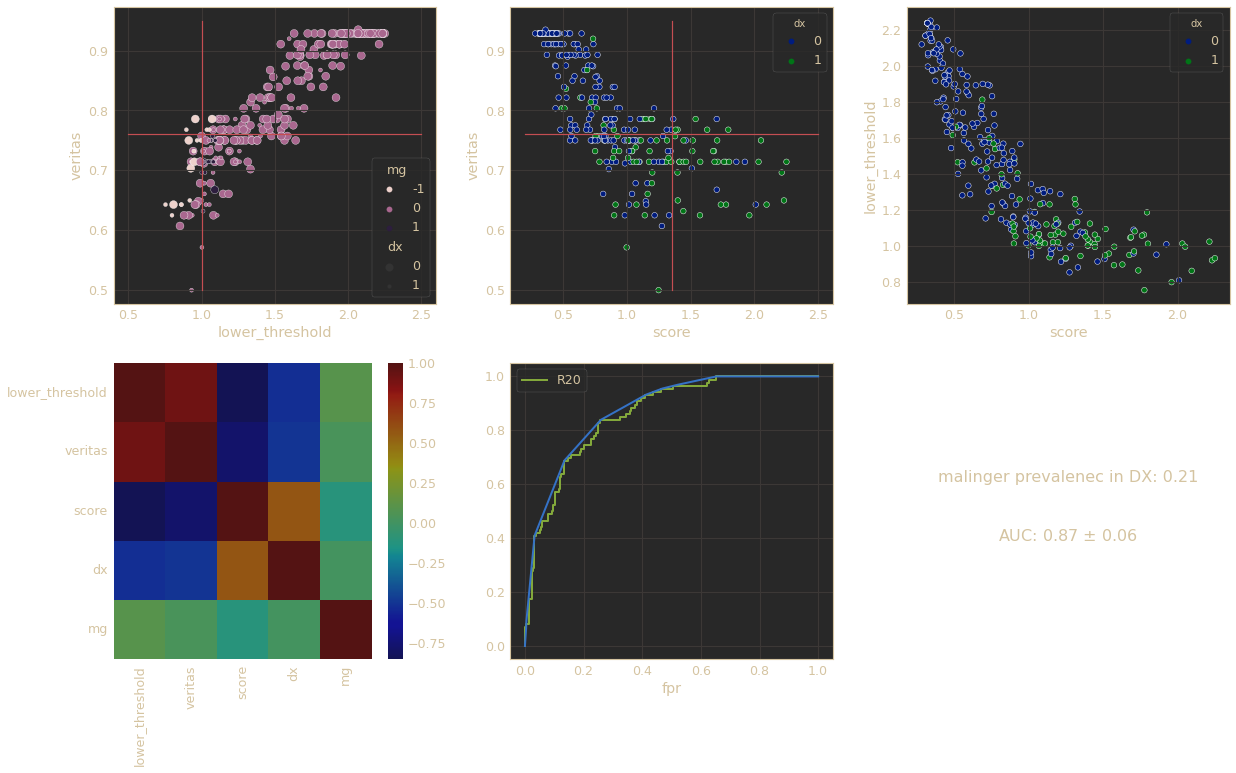

In [51]:
plt.style.use('seaborn-dark-palette')

plt.figure(figsize=[20,12])
plt.subplot(231)
sns.scatterplot(data=resf,x='lower_threshold',y='veritas',hue='mg',size='dx')
plt.plot([.5,2.5],[.76,.76],'-r')
plt.plot([C0,C0],[.5,.95],'-r')

plt.subplot(232)
ax=sns.scatterplot(data=resf,x='score',y='veritas',hue='dx')
plt.plot([.2,2.5],[C1,C1],'-r')
plt.plot([C2,C2],[.5,.95],'-r')

plt.subplot(233)
sns.scatterplot(data=resf,x='score',y='lower_threshold',hue='dx')
plt.subplots_adjust(wspace=0.23)  # Adjust this value as needed

cf=resf.corr()
plt.subplot(234)
sns.heatmap(cf,cmap='jet',alpha=.5)
mratio=(resf[(resf.mg==-1) & (resf.dx==1)].index.size)/86


plt.subplot(235)

plt.plot(fpr,tpr,'g',lw=2)
plt.gca().legend(['R20'])
zt.get().tpr.plot(style='-b',lw=2)
fullauc=zt.auc()


ax = plt.subplot(236)

# Printing values in the subplot
ax.text(0.5, 0.6, f'malinger prevalenec in DX: {mratio:.2f}', fontsize=16, ha='center')
ax.text(0.5, 0.4, f'AUC: {fullauc[0]:.2f} $\pm$ {fullauc[1]-fullauc[0]:.2f}', fontsize=16, ha='center')

# Setting up the subplot (like removing axes)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.savefig('report9.png',dpi=300,bbox_inches='tight',transparent=True)

In [1]:
! pwd

/home/ishanu/ZED/Research/truthnet/veritas_test/ntb
